In [1]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

country_summary = pd.read_csv('countries.csv')
user_summary = pd.read_csv('age_gender_bkts.csv')
users = pd.read_csv('train_users_2.csv')
sessions = pd.read_csv('sessions.csv')

Populating the interactive namespace from numpy and matplotlib


# Predicting Hotel Bookings

## Introduction to Problem

We are explorinng data from a popular crowdsourcing company in the hotel industry. We are attempting to predict if a new user who signs up for the website will make a booking, and if so, which country they will make that booking in. This insight would be valuable in helping the company both increase sales and improve user experience by allowing the the company to present relevant booking suggestions for the specific user.

## Examine and Clean Data

Our data set consists of three different tables: user summary statistics, country summary statistics, user web session data, and user data and their first bookings (if any). We have 213,451 data points to work with, but the data is not clean we have many missing fields. The data from 2010 to 2014. Below are some excerpts of our data set, as well as some code to clean, subset, and reshape our data for exploration. The user summary statistics present summary information on new users in 2015 - we may reference this later to see if user preferences change from the 2010-2014 period, but the data is limited so we will ignore it for now. The web session data set include information on how the user interacted with the website, which may be interesting in terms of website improvement, but not particualrly helpful in predicting destination choices. For the sake of this analysis, we will be working with the country summary statistics and the main data set, joining the two tables by the First Destination Country of the user. We may also join the web sesions data just in case we see any patterns in terms of method of access to the website.

### Country Summary Statistics

Lets begin by examining our summary statistic table for the countries of travel.

In [2]:
country_summary.head()

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06


We can see below that we are working with 9 different countires, their locations, and some other statitics. With some quick research, we find the definitions of the country and language codes and append these values to our table. 

In [3]:
country_summary['countries'] = ['Australia', 'Canada', 'Germany', 'Spain', 'France', 
                                     'United Kingdom', 'Italy', 'Netherlands', 'Portugal', 'United States']
country_summary['languages'] = ['English', 'English', 'German', 'Spanish', 'French', 
                                'English', 'Italian', 'Dutch', 'Portuguese', 'English']

With a little additional research, the distance_km column indicates the distance between the United States and the country in each row. We can see that the distance_km for US is 0. Additionally, there is a column destination_km2, which appears to be distances to the destination squared. We can tell by the massive distances, the Earth has a circumference of about 40,000 km for reference. Lets adjust. Since we have these values, we can also remove longitude and latitude information. 

In [4]:
country_summary['destination_dst'] = np.sqrt(country_summary['destination_km2'])
del country_summary["destination_km2"] 
del country_summary["lat_destination"]
del country_summary["lng_destination"]

In [5]:
country_summary

,country_destination,distance_km,destination_language,language_levenshtein_distance,countries,languages,destination_dst
0,AU,15297.7440,eng,0.00,Australia,English,2782.304800
1,CA,2828.1333,eng,0.00,Canada,English,3159.852845
2,DE,7879.5680,deu,72.61,Germany,German,597.513180
3,ES,7730.7240,spa,92.25,Spain,Spanish,710.893804
4,FR,7682.9450,fra,92.06,France,French,802.372108
5,GB,6883.6590,eng,0.00,United Kingdom,English,493.568638
6,IT,8636.6310,ita,89.40,Italy,Italian,548.944442
7,NL,7524.3203,nld,63.22,Netherlands,Dutch,203.821000
8,PT,7355.2534,por,95.45,Portugal,Portuguese,303.463342
9,US,0.0000,eng,0.00,United States,English,3134.752781


After adjusting the distances using the numpy sqrt function, we can see that the 'destination_km'apperas to be the distance from the country to the actual hotel destinations. We see that travelers who stay within the US or go to Canada have to travel the further to their destination upon reching the country, while travelers going to the smaller European countries consistently travel less than 1000 km upon reaching the country. Finally, lets look at the column language_levenshtein_distance. Levenshtein distance is a metric used to guage the differences in the language by measuring the number of single character edits used to change a word into another. While we don't know the exact computation of the Levenshtein distances in the table, we can use it as a quantifiable difference between English and the language of the destination country (assuming that language is not English). We can see that of the non-English speaking destinations, Dutch is the most similar and Portuguese is the most different. 

### Main User Data

Lets take a look at our main user data set. We have 213451 entries, with 16 columns, shown below. 

In [6]:
len(users.columns),len(users)

(16, 213451)

In [7]:
users.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')

In [8]:
users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


We have unique identifier, the date of account creation, and the timestamp of activation. Since we already have the date of account creation, we do not need to first active time. We also have the date of the first booking, gender, age and signup method. Signup flow is the page a user came to sign up from. We have language, which is the user's international language preference. We also have Affiliate data and date about each user's first signup. Since we have the first device, browser, and signup method, we will not need more detailed web session data. Finally, we have their first destination country. Several of these columns will be helpful in analyzing user booking patterns.

### Further Explorartion and Data Cleanup

Lets explore the NA values and missing data among our set. We will also clean up "bad" data, where users may have incorrectly entered data or falsified personal information. First lets delete columns we will not be using.

In [9]:
del users['timestamp_first_active']
del users['signup_flow']
del users['affiliate_channel']
del users['first_affiliate_tracked']

In [10]:
users['gender'].unique()
users['gender']=users['gender'].replace('-unknown-', np.nan)

In [11]:
users.isnull().sum()

id                           0
date_account_created         0
date_first_booking      124543
gender                   95688
age                      87990
signup_method                0
language                     0
affiliate_provider           0
signup_app                   0
first_device_type            0
first_browser                0
country_destination          0
dtype: int64

We can see that we are missing a lot of data, particularly in date_first_booking, gender, and age. These are 3 crucial variables, but luckily we have a large data set. Lets look at the missing data. We can see below that the country_destination has a value of 'NDF' - this indicates No Destination Found. In other words, these are users that signed up for the website but did not actually make a booking - about 42% of website signups actually made a booking. This explains the missing values for date of first booking.

In [12]:
users[['country_destination', 'date_first_booking']].head()

,country_destination,date_first_booking
0,NDF,NaN
1,NDF,NaN
2,US,2010-08-02
3,other,2012-09-08
4,US,2010-02-18


In [13]:
1-sum(users['country_destination']=='NDF')/len(users)

0.4165265095970504

Next, let's consider the missing values in Gender. Although we have a lot of missing values, we can assumes the data we do have is true. We don't have reason to believe that a significant number of users would have provided inaccurate information about their gender - the 95.7 thousand missing values would indicate the the field was optional (also because "other" was a gender option).

In [14]:
users.gender.unique()

array([nan, 'MALE', 'FEMALE', 'OTHER'], dtype=object)

Finally, lets look at age - we know that our age data is off. Website users must be over the age of 18 to sign up, yet our age distribution indicates very young and very old users. Additionally, although it is possible for elderly users (90+) to use the website, we saw earlier that this group is a minority in terms of travelers. Lets ignore these values, (which will also weed out fake ages, like 112). Before we do that, we make sure to convert people who accidentally used their birth year instead of their age. The code to perform this cleanup is given below:

In [15]:
users.groupby('age').count()['id'].head()

age
1.0      2
2.0      7
4.0      3
5.0     45
15.0     8
Name: id, dtype: int64

In [16]:
users.groupby('age').count()['id'].tail()

age
1953.0      1
1995.0      1
2008.0      1
2013.0     39
2014.0    710
Name: id, dtype: int64

In [17]:
#Convert dates to useable formats
users['date_account_created'] = users['date_account_created'].apply(lambda x: pd.tslib.Timestamp(x))

In [18]:
users['date_first_booking'] = users['date_first_booking'].apply(lambda x: pd.tslib.Timestamp(x))

In [19]:
users['created_year'] = users['date_account_created'].apply(lambda x: x.year)
users["age"] = users.apply(lambda r: (r["created_year"] - r["age"]) if r["age"] > 1000 else r["age"], axis=1)
# Remove outliers that we consider 'fake'
users['age'] = users['age'].apply(lambda x: np.nan if x>90 else x)
users['age'] = users['age'].apply(lambda x: np.nan if x<18 else x)

### Adding calculated columnns - Age Group, Language, Levenshtein Distance, Month 

To make age a useful variabel to model with, lets add an age group column to indicate what generation a user was born into. We will use the following age groups: GI Generation (born <= 1924), Silent Generation(1925-1942), Baby Boomers (1943-1960), Generation X (1961-1980), and the Millenials (1981-1996)

In [20]:
users['birthYear'] = users['created_year']-users['age']

In [21]:
users['ageGroup'] = np.nan
users['ageGroup'][users['birthYear'] <= 1996] = "Millenial"
users['ageGroup'][users['birthYear'] <= 1980] = "Generation X"
users['ageGroup'][users['birthYear'] <= 1960] = "Baby Boomers"
users['ageGroup'][users['birthYear'] <= 1942] = "Silent Generation"
users['ageGroup'][users['birthYear'] <= 1924] = "GI Generation"


/Users/Akaash/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Akaash/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/Akaash/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Akaash/anaconda3/lib/python3.5/site-packages/ipyker

Next, lets add destination_language and language_levenshtein_distance from our country summary statistics. It will be useful to compare how different demographics within our data set choose destinations differently based on the language spoken there. 

In [22]:
lang_summary = country_summary[['country_destination', 'destination_language ', 'language_levenshtein_distance']]
add_language = pd.merge(users, lang_summary, how='left', on='country_destination')

In [23]:
add_language.head()

,id,date_account_created,date_first_booking,gender,age,signup_method,language,affiliate_provider,signup_app,first_device_type,first_browser,country_destination,created_year,birthYear,ageGroup,destination_language,language_levenshtein_distance
0,gxn3p5htnn,2010-06-28,NaT,NaN,NaN,facebook,en,direct,Web,Mac Desktop,Chrome,NDF,2010,NaN,NaN,NaN,NaN
1,820tgsjxq7,2011-05-25,NaT,MALE,38.0,facebook,en,google,Web,Mac Desktop,Chrome,NDF,2011,1973.0,Generation X,NaN,NaN
2,4ft3gnwmtx,2010-09-28,2010-08-02,FEMALE,56.0,basic,en,direct,Web,Windows Desktop,IE,US,2010,1954.0,Baby Boomers,eng,0.0
3,bjjt8pjhuk,2011-12-05,2012-09-08,FEMALE,42.0,facebook,en,direct,Web,Mac Desktop,Firefox,other,2011,1969.0,Generation X,NaN,NaN
4,87mebub9p4,2010-09-14,2010-02-18,NaN,41.0,basic,en,direct,Web,Mac Desktop,Chrome,US,2010,1969.0,Generation X,eng,0.0


### Split data set into two: Bookings and Nonbookings

In [24]:
bookings = add_language[add_language['country_destination']!='NDF']
nonbookings = add_language[add_language['country_destination']=='NDF']
len(bookings), len(nonbookings), len(bookings)/len(add_language)

(88908, 124543, 0.4165265095970504)

As mentioned earlier, about 42% of website signups turned into actual bookings. We subset our main data to contain only these users, and call this table 'bookings'. This gives us 88,908 booking data points to analyze. There might also be some useful patterns in users who didn't make bookings, so we save this data to a table called 'nonbookings'. 

In [25]:
bookings['booking_month'] = bookings['date_first_booking'].apply(lambda x: x.month)
bookings['booking_year'] = bookings['date_first_booking'].apply(lambda x: x.year)

/Users/Akaash/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Akaash/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [26]:
bookings = bookings.dropna()
len(bookings)

49507

## Summary statistics and Exploratory Data Analysis

Now we have a clean data set of bookings of size 49507 to work with. Lets explore the data further.

### Age Distribution

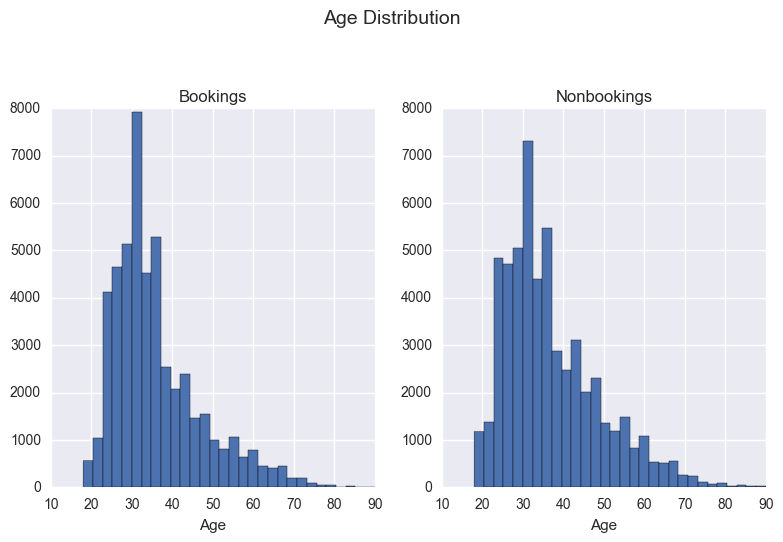

In [27]:
bkage = bookings.age
nbkage = nonbookings.age

plt.subplot(1,2,1)
bkage.hist(bins=30)
xlabel('Age')
plt.title('Bookings')

plt.subplot(1, 2, 2)
nbkage.hist(bins=30)
xlabel('Age')
plt.title('Nonbookings')

plt.suptitle("Age Distribution", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.8)
plt.show()

### Gender Distribution

In [28]:
bkgender = bookings['gender']
nbkgender = nonbookings['gender']

bkgender.value_counts() 

FEMALE    26619
MALE      22748
OTHER       140
Name: gender, dtype: int64

In [29]:
nbkgender.value_counts() 

FEMALE    31048
MALE      26719
OTHER       106
Name: gender, dtype: int64

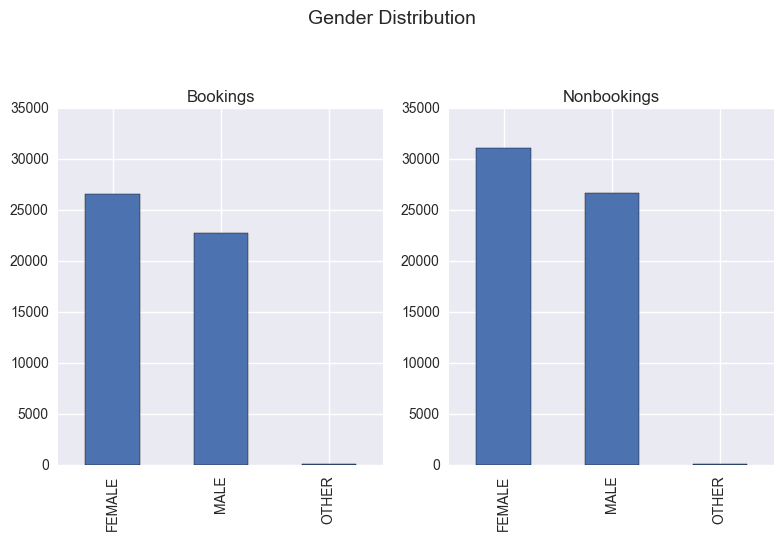

In [30]:
plt.subplot(1,2,1)
bkgender.value_counts().plot(kind='bar')
ylim(0, 35000)
plt.title('Bookings')

plt.subplot(1, 2, 2)
nbkgender.value_counts().plot(kind='bar')
plt.title('Nonbookings')

plt.suptitle("Gender Distribution", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=.8)
plt.show()

### Country of destination

In [31]:
dest = users['country_destination'].dropna(how='any')
dest.value_counts('NDF')*100

NDF      58.347349
US       29.222632
other     4.728954
FR        2.353233
IT        1.328174
GB        1.088774
ES        1.053638
CA        0.669006
DE        0.497070
NL        0.356991
AU        0.252517
PT        0.101663
Name: country_destination, dtype: float64

Over half of the user sign ups did not end up booking a destination, and about 41% do. Not surprisingly, most first bookings by Americans occur domestically. Next, lets look at the distribution of actual first bookings (no NDF values or US values) outside the US.

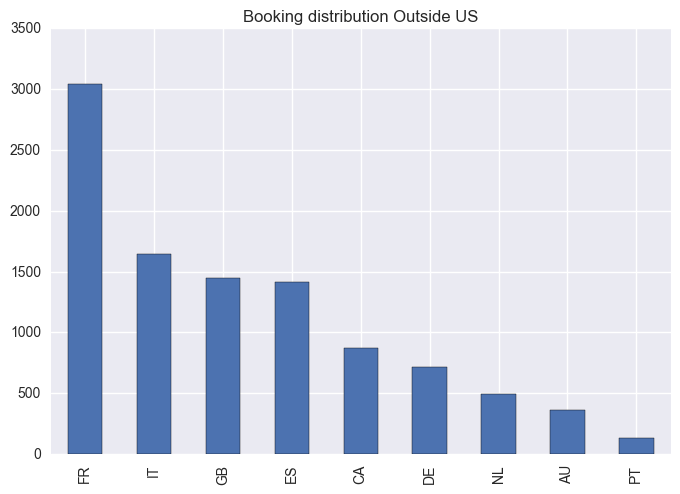

In [32]:
bookings[bookings['country_destination'] != 'US']['country_destination'].value_counts().plot(kind='bar')
plt.title('Booking distribution Outside US')

### International Language Preference

Lets contrast this with the distribution of the international language preferences.

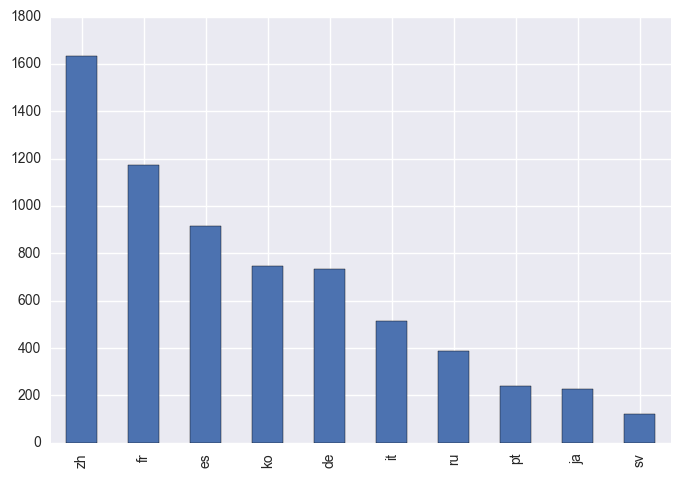

In [33]:
languages = users['language'].dropna(how='any')
languages.value_counts()
languages_foreign = languages[languages!='en']
lang_pop = languages_foreign.value_counts()
lang_pop = lang_pop[lang_pop>100]
lang_pop.plot(kind='bar')

Note: Zh is chinese, and Ko is Korean. It appears that the 'Other' bookings would contain several bookings in China or Hong Kong and Korea. French is the second most preferred international language, followed by Spanish. Italian is the sixth most preferred international language, but Italy is the second most booked destination country. 

### Distance Traveled

Lets contrast the actual bookings and language preferences to the distance the user would need to travel - there doesn't appear to be any sort of relationship worth exploring.

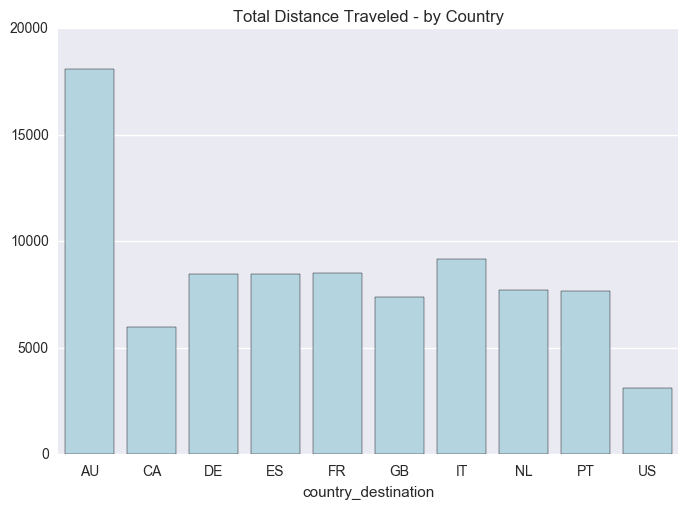

In [34]:
ax = plt.axes()
sns.barplot(x=country_summary['country_destination'], 
            y=country_summary['destination_dst']+country_summary['distance_km'],
            color="lightblue", ax=ax)
ax.set_title('Total Distance Traveled - by Country')

### Signup Method 

Lets take a look at the methods of first access. We see that most people accessed the booking website directly, via web browser on their Mac or PC. It might be interesting to investigate this further by categorizing our data by age groups. 

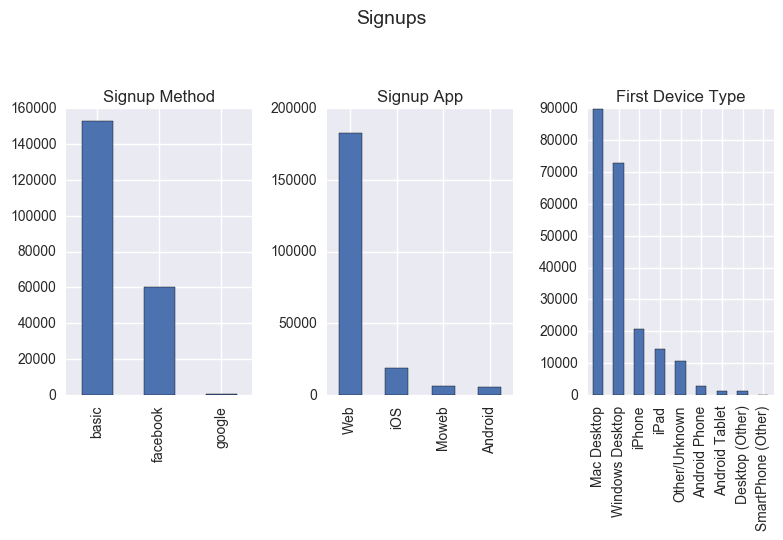

In [35]:
plt.subplot(1,3,1)
users['signup_method'].value_counts().plot(kind='bar')
plt.title('Signup Method')

plt.subplot(1, 3, 2)
users['signup_app'].value_counts().plot(kind='bar')
plt.title('Signup App')

plt.subplot(1, 3, 3)
users['first_device_type'].value_counts().plot(kind='bar')
plt.title('First Device Type')

plt.suptitle("Signups", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=.8)
plt.show()

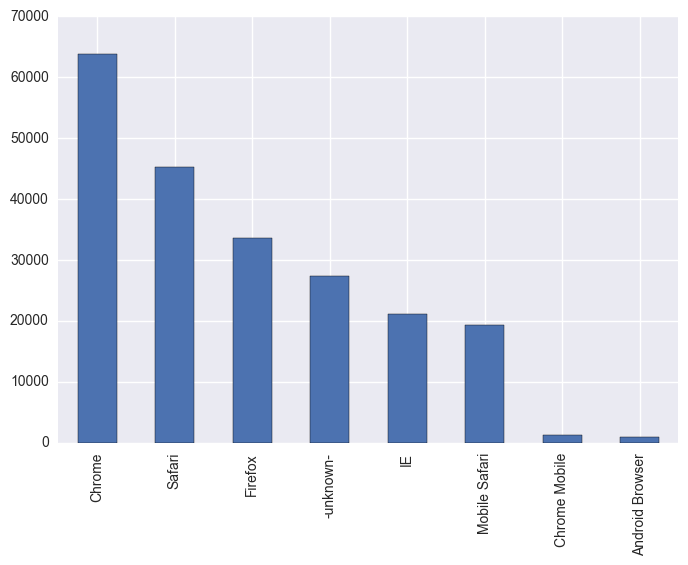

In [36]:
browser_counts = users['first_browser'].value_counts()
browser_counts[browser_counts>600].plot(kind='bar')

We see that most of our data is coming from users on popular web browsers - Chrome, Safari, Firefox and Internet Explorer. It is interesting that "unknown" ranks higher than Internet Explorer. However, given the large list of browsers including lest popular options like Opera, we are inclined to believe that the browser of those data points is simply just unknown and probably largely comprised of the popular browsers.

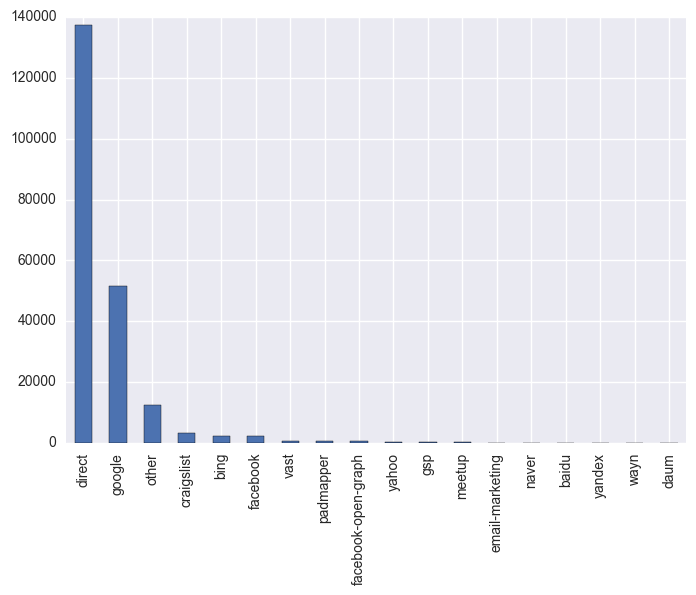

In [37]:
users['affiliate_provider'].value_counts().plot(kind='bar')

The graph above shows affiliate marketing data. We can see that most users first accessed the website directly - meaning that they knew about the website already, rather than stumbling upon it through another source. The next highest group consists of users who found the website through google - possibly by searching for hotels or even just the website directly. The third largest group of users found site through "other" - possibly a link from a friend or a website whose data we don't have. This is interesting, but may not be indicative of where the user will be booking since the vast majority of users either directly accessed the website first or found it through a Google search. These attributes wouldn't seem to be exclusive to any specific group of people. 

### Bivariate / Multivariate Exploration

### Who is actually making bookings?

In [38]:
booking_counts = bookings.groupby(['gender', 'ageGroup', 'country_destination']).count().sort_values('id')
booking_counts['id']

gender  ageGroup           country_destination
OTHER   Generation X       IT                         1
        Baby Boomers       IT                         1
        Millenial          PT                         1
                           GB                         1
                           ES                         1
                           DE                         1
MALE    Silent Generation  AU                         1
OTHER   Generation X       DE                         1
FEMALE  GI Generation      CA                         1
                           IT                         1
                           NL                         1
OTHER   Baby Boomers       DE                         1
        Millenial          AU                         1
        Generation X       NL                         1
FEMALE  Silent Generation  ES                         2
OTHER   Generation X       GB                         2
FEMALE  Silent Generation  AU                         2
O

In [39]:
nonbooking_counts = nonbookings.groupby(['gender', 'ageGroup']).count().sort_values('id')
nonbooking_counts['id']

gender  ageGroup         
OTHER   Silent Generation        3
        Baby Boomers             4
MALE    GI Generation            8
FEMALE  GI Generation            9
OTHER   Millenial               26
        Generation X            32
MALE    Silent Generation      289
FEMALE  Silent Generation      312
MALE    Baby Boomers          2283
FEMALE  Baby Boomers          3054
MALE    Millenial            10130
        Generation X         11191
FEMALE  Generation X         11487
        Millenial            12224
Name: id, dtype: int64

The tables above indicate that the highest number of website signups occur among Female millenials. The highest number of actual bookings from these account signups are also female millenials. And as we already knew, the large majority of first bookings occurred within the U.S. 

### Time between account creation and first booking?

In [40]:
bookings['time_til_booking'] = bookings['date_first_booking'] - bookings['date_account_created']

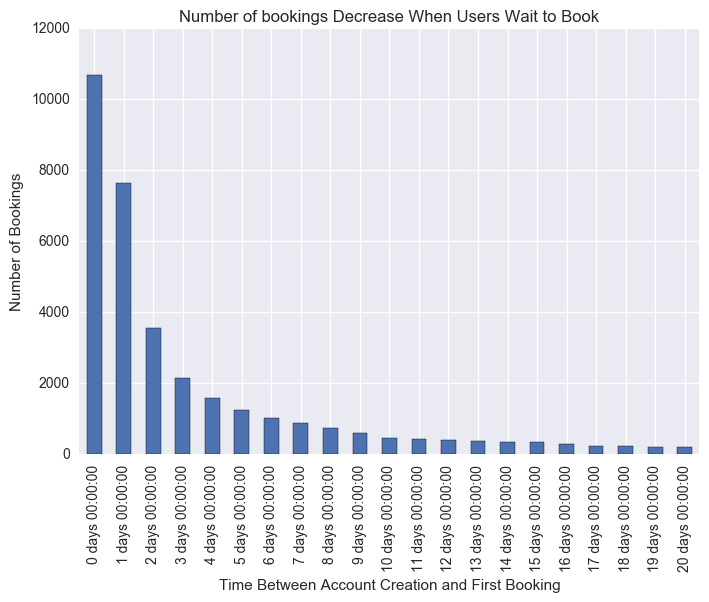

In [41]:
bookings[bookings['time_til_booking'] >= '0 days'].groupby('time_til_booking').count()['id'].sort_values(ascending=False)
bookings[(bookings['time_til_booking'] >= '0 days') & (bookings['time_til_booking'] <= '20 days')].groupby('time_til_booking').count()['id'].plot(kind='bar')
plt.title('Number of bookings Decrease When Users Wait to Book')
plt.xlabel('Time Between Account Creation and First Booking')
plt.ylabel('Number of Bookings')

There is a clear pattern here. The most number of users made their first booking immediately after creating their account. The more time that passes after account creation, it appears to be less likely for the user to actually make their first booking.

### Do Americans prefer to travel to to English speaking countries? Are there differences between the age groups? The genders?

Compare proportion of english speaking destinations to non. Compare proportion of males who picked English to Females who picked english speaking countries. Similarly, do the same between age groups.  

In [42]:
sum(bookings['country_destination']=='US')/len(bookings['country_destination'])

0.795261276183166

In [43]:
sum(bookings['destination_language ']=='eng') / len(bookings['destination_language '])

0.84959702668309534

We can see that not only did most (70%) Americans who made a booking stayed within the states, 85% of of Americans who made a booking did so in an English speaking country. This is not surprising. Domestic travel is less costly and more comfortable due to familiarity. Additionally, this crowdsourcing website is an American company which started domestically and then expanded internationally, so it follows that more of our data would encompass domestic bookings. While this is not surprising, we should take this account when exploring our data. Lets create another data frame to explore international travel - we can explore this further by countries that speak english and countries that don't.

In [44]:
int_bookings = bookings[bookings.country_destination!="US"]

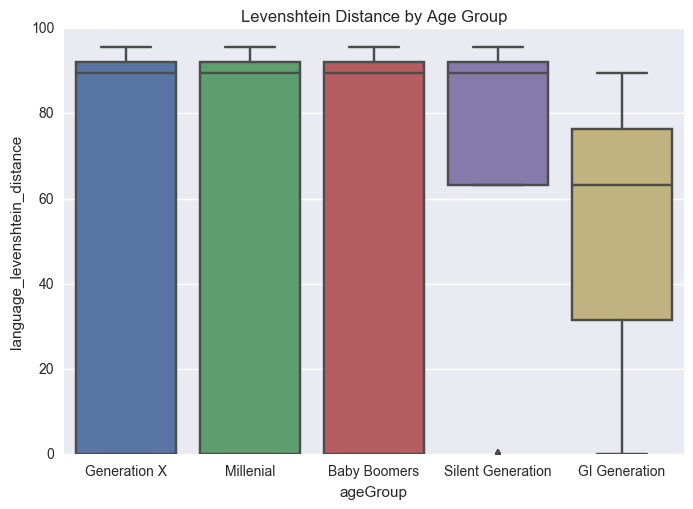

In [45]:
ax = sns.boxplot(x="ageGroup", y="language_levenshtein_distance", data=int_bookings)
ax.set_title('Levenshtein Distance by Age Group')

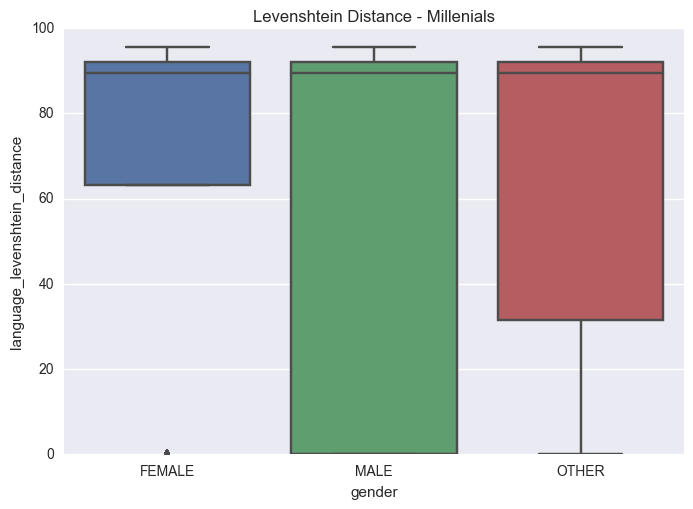

In [46]:
ax = sns.boxplot(x="gender", y="language_levenshtein_distance", data=int_bookings[int_bookings['ageGroup']=='Millenial'])
ax.set_title('Levenshtein Distance - Millenials')

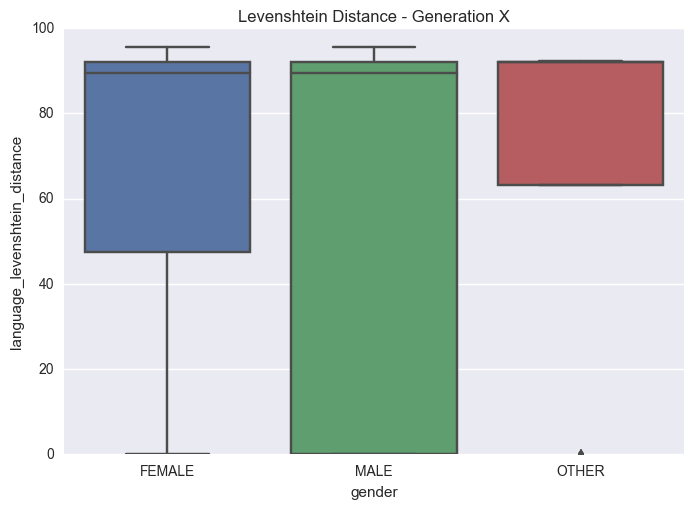

In [47]:
ax = sns.boxplot(x="gender", y="language_levenshtein_distance", data=int_bookings[int_bookings['ageGroup']=='Generation X'])
ax.set_title('Levenshtein Distance - Generation X')

Amongst all of the age, groups, members of the GI Generation (the generation who experienced World War II), tended to choose more familiar locations for their locations. We base this off the Levenshtein numbers on the y-axis of the Boxplots, which measures a country's language distance from English. We also take a closer look into our highest demographic of destination bookers - females of the Millenial and Generation X age groups. A larger percentile of females made bookings in more 'foreign' countries - countries where the languages deviated further from English compared to the countries that the males booked in. So not only did females (younger and middle aged) make more bookings compared to males in our sample, they also tended to make more adventurous bookings!

### What booking tendancies for travel destinations can you observe by group? Are there differences between the age groups? The genders? Signup Method?

In [48]:
df = int_bookings[int_bookings['country_destination']!=NAN]

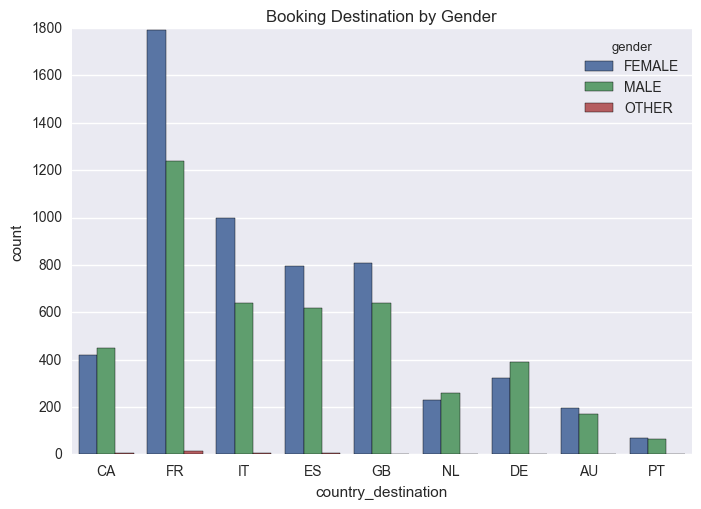

In [49]:
ax = sns.countplot(x='country_destination', data=df, hue='gender')
ax.set_title('Booking Destination by Gender')

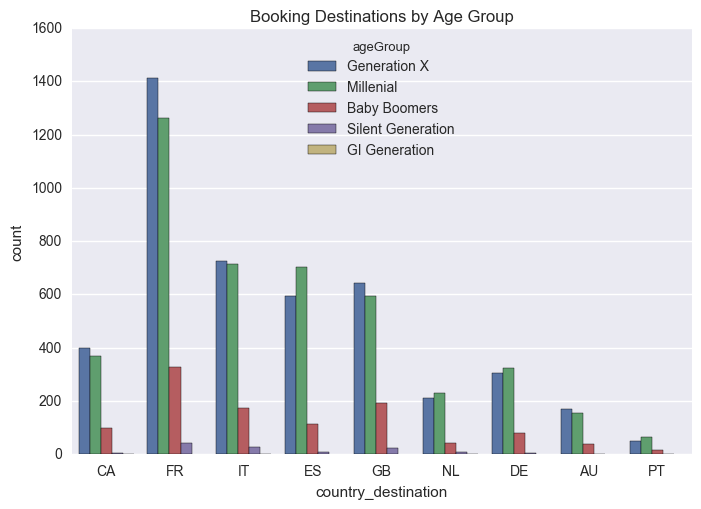

In [50]:
ax = sns.countplot(x='country_destination', data=df, hue='ageGroup')
ax.set_title('Booking Destinations by Age Group')

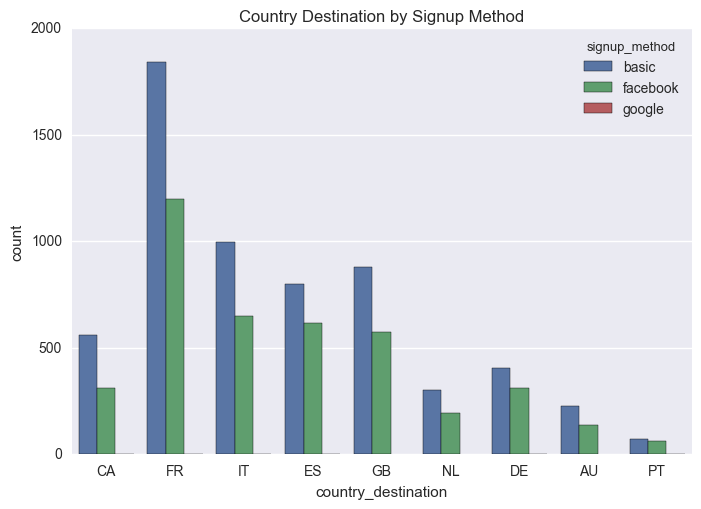

In [52]:
ax=sns.countplot(x='country_destination', data=df, hue='signup_method')
ax.set_title('Country Destination by Signup Method')

In the three count plots above, we explore how the distributions of non US bookings vary among different groups in our data. In the first plot we explore the difference in bookings between gender. When we look at the named non-Us countries, we can see more specifically how millenials and Generation X consist of most bookings, and how these bookings are distributed. 

### Is there a seasonal impact (does the time year affect the country booked)?

Try scatter plot for number of bookings over time. Then try line graph, one line for each country, for number of bookings over time. Can you split over genders?

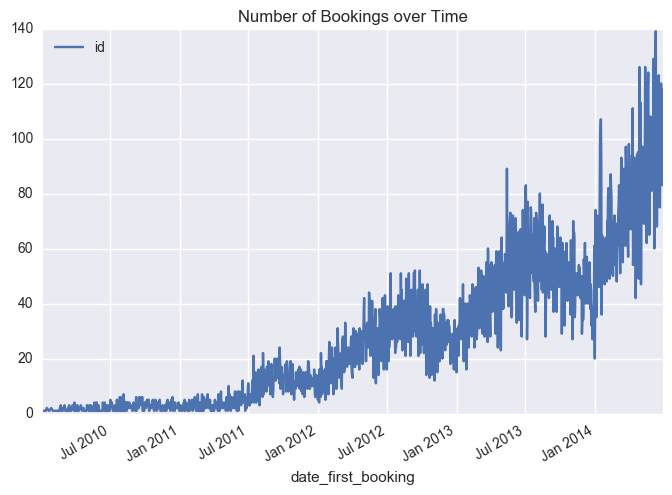

In [53]:
time_df = bookings.groupby('date_first_booking')['id'].count()
time_df = time_df.reset_index()
time_df['date_first_booking'] = pd.to_datetime(time_df['date_first_booking'])
time_df = time_df[time_df['date_first_booking']<'7/1/2014']
ax = time_df.plot(x=time_df['date_first_booking'])
ax.set_title('Number of Bookings over Time')

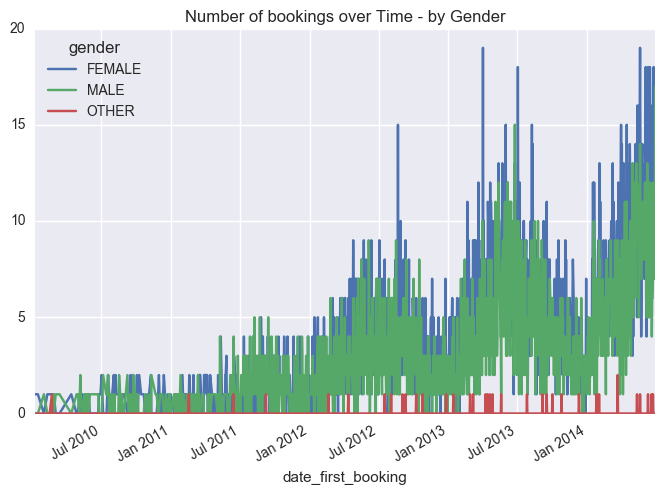

In [54]:
time_df2 = df.groupby(['date_first_booking', 'gender'])['id'].count()
time_df2 = time_df2.unstack('gender').fillna(0)
time_df2=time_df2.reset_index()
time_df2 = time_df2[time_df2['date_first_booking']<'7/1/2014']
ax = time_df2.plot(x=time_df2['date_first_booking'])
ax.set_title('Number of bookings over Time - by Gender')

We can see a cyclical trend here. Booking peaks little past the halfway point for each year (July-August). This would make sense - this alligns with Summer holidays for college students and families with children. Additionally the weather is consistently warm across the United States. However, there is an unexpected trend - bookings tend to dip around the winter holidays each year and then start to rise again with the each new year consistently until the early Fall months. This could possibly be explained by New Years marketing campaigns by the website, or the fact that people choose to spend the Winter holidays with their families (Thanksgiving, Christmas), and choose to travel when the weather warms. 

In [55]:
bookings.groupby('country_destination').count()['id'].sort_values()

country_destination
PT      134
AU      367
NL      492
DE      716
CA      872
ES     1417
GB     1451
IT     1645
FR     3042
US    39371
Name: id, dtype: int64

## Bookings by Month

The following bar plots explore the number of bookings made in each of the 11 destination countries. The x axis values of 1-12 for "booking month" represent January - December. The graphs are presented in decsending order of number of bookings made at that country, with the United States appearing first and Portugal appearing last. We are attempting to identify any seasonality patterns in the data, and if bookings vary in different months between the different countries.

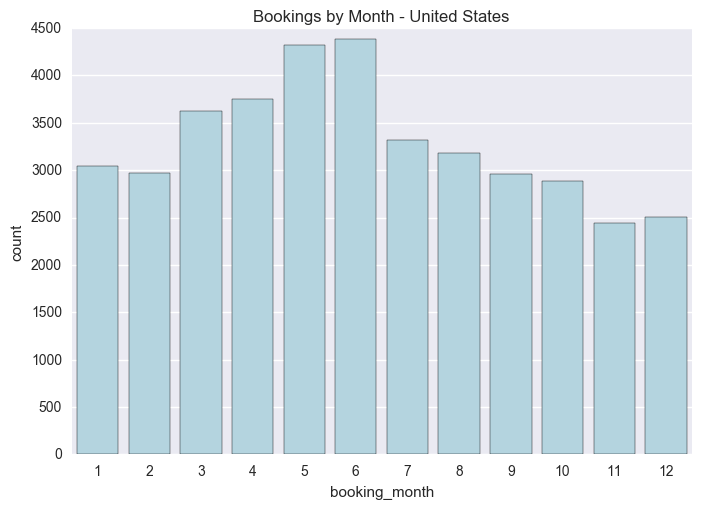

In [56]:
ct='US'
bookings_ct = bookings[bookings['country_destination']==ct]
ax = sns.countplot(x='booking_month', data=bookings_ct, color='lightblue')
ax.set_title('Bookings by Month - United States')

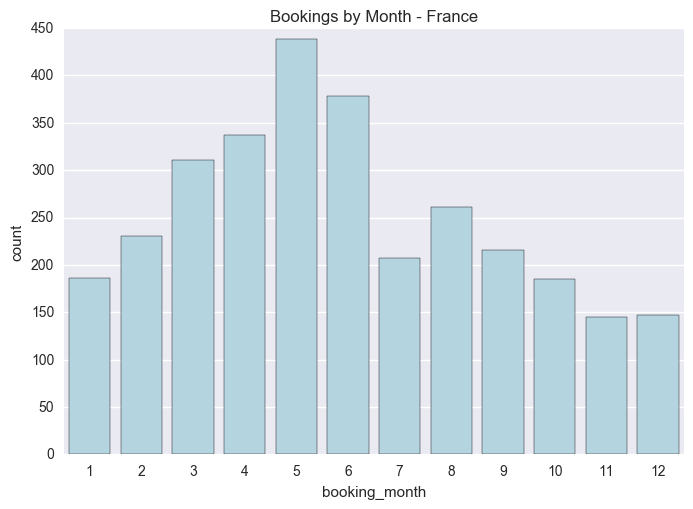

In [57]:
ct='FR'
bookings_ct = bookings[bookings['country_destination']==ct]
ax = sns.countplot(x='booking_month', data=bookings_ct, color='lightblue')
ax.set_title('Bookings by Month - France')

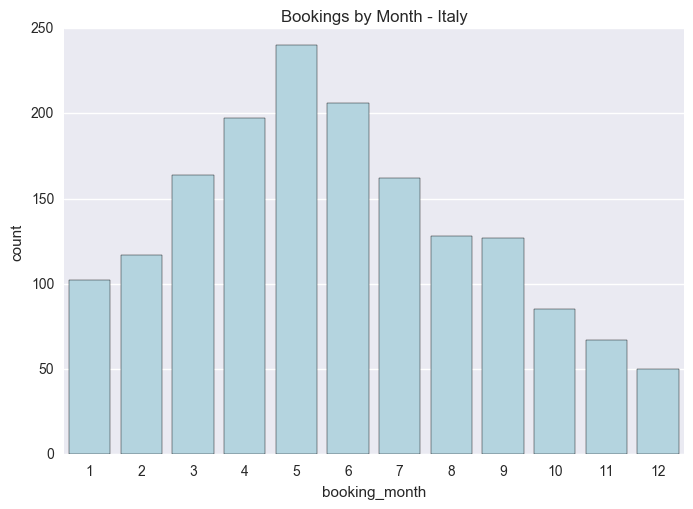

In [58]:
ct='IT'
bookings_ct = bookings[bookings['country_destination']==ct]
ax = sns.countplot(x='booking_month', data=bookings_ct, color='lightblue')
ax.set_title('Bookings by Month - Italy')

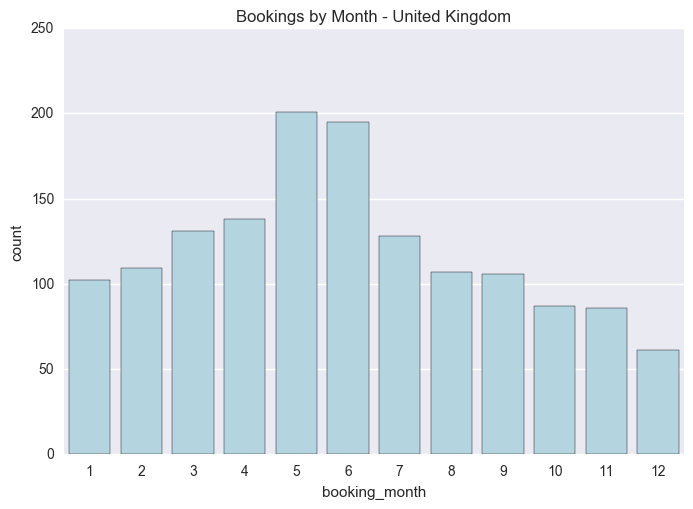

In [59]:
ct='GB'
bookings_ct = bookings[bookings['country_destination']==ct]
ax = sns.countplot(x='booking_month', data=bookings_ct, color='lightblue')
ax.set_title('Bookings by Month - United Kingdom')

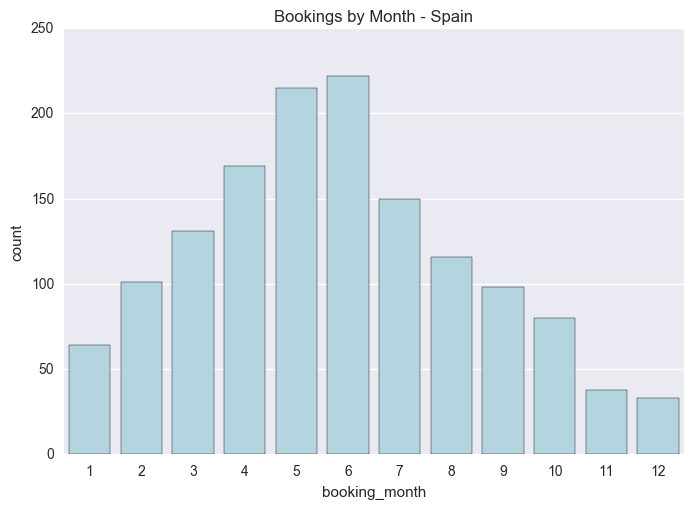

In [60]:
ct='ES'
bookings_ct = bookings[bookings['country_destination']==ct]
ax = sns.countplot(x='booking_month', data=bookings_ct, color='lightblue')
ax.set_title('Bookings by Month - Spain')

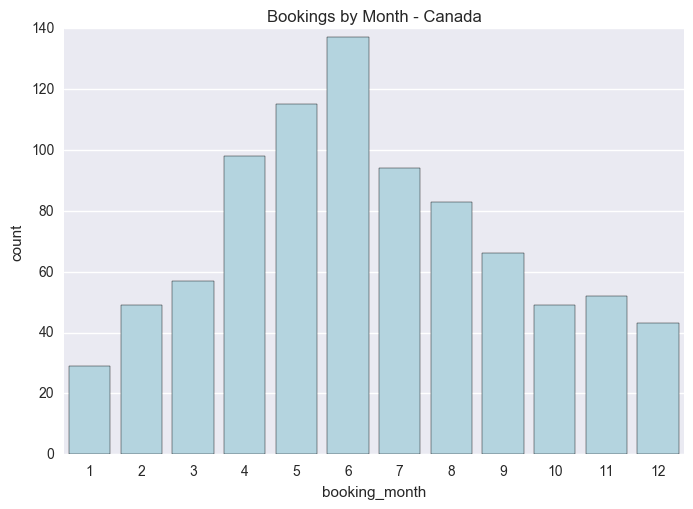

In [61]:
ct='CA'
bookings_ct = bookings[bookings['country_destination']==ct]
ax = sns.countplot(x='booking_month', data=bookings_ct, color='lightblue')
ax.set_title('Bookings by Month - Canada')

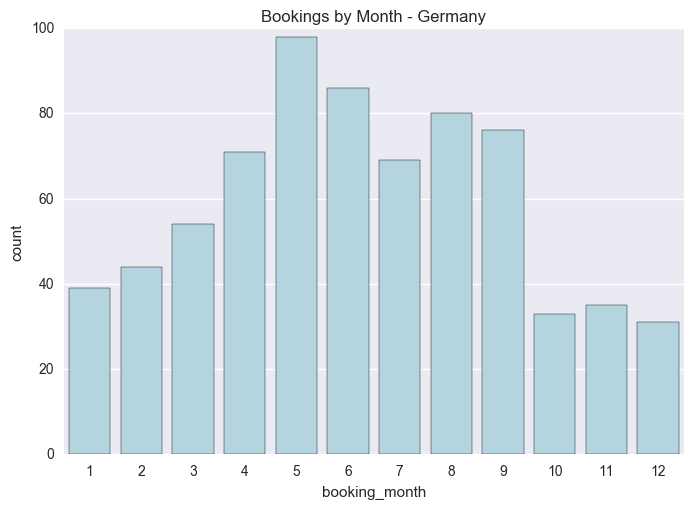

In [62]:
ct='DE'
bookings_ct = bookings[bookings['country_destination']==ct]
ax = sns.countplot(x='booking_month', data=bookings_ct, color='lightblue')
ax.set_title('Bookings by Month - Germany')

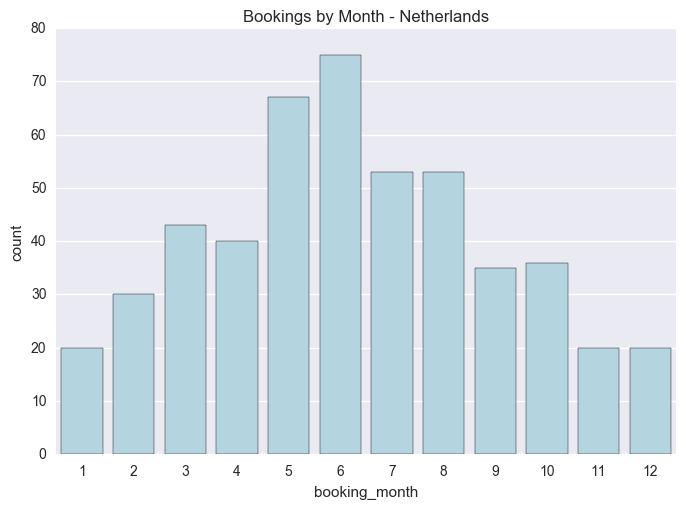

In [63]:
ct='NL'
bookings_ct = bookings[bookings['country_destination']==ct]
ax = sns.countplot(x='booking_month', data=bookings_ct, color='lightblue')
ax.set_title('Bookings by Month - Netherlands')

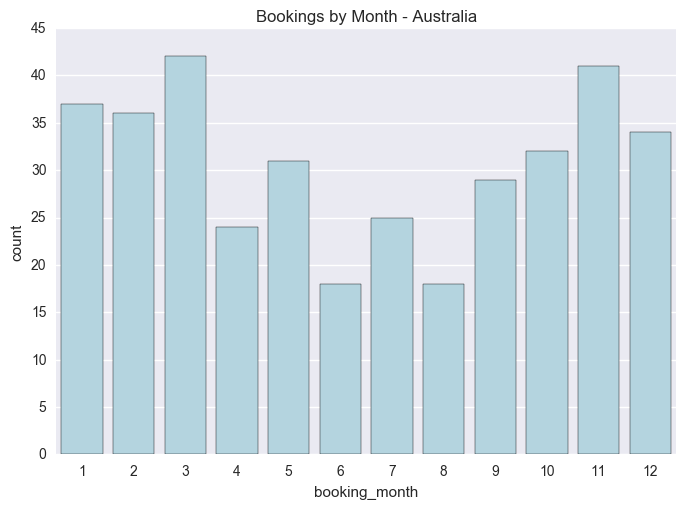

In [64]:
ct='AU'
bookings_ct = bookings[bookings['country_destination']==ct]
ax = sns.countplot(x='booking_month', data=bookings_ct, color='lightblue')
ax.set_title('Bookings by Month - Australia')

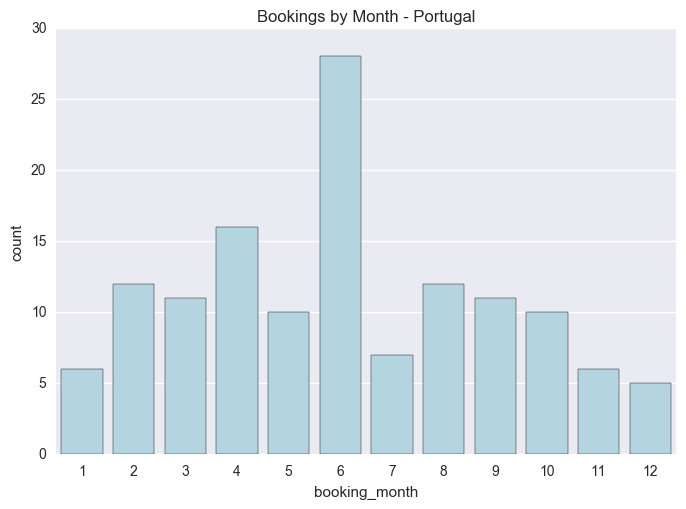

In [65]:
ct='PT'
bookings_ct = bookings[bookings['country_destination']==ct]
ax = sns.countplot(x='booking_month', data=bookings_ct, color='lightblue')
ax.set_title('Bookings by Month - Portugal')

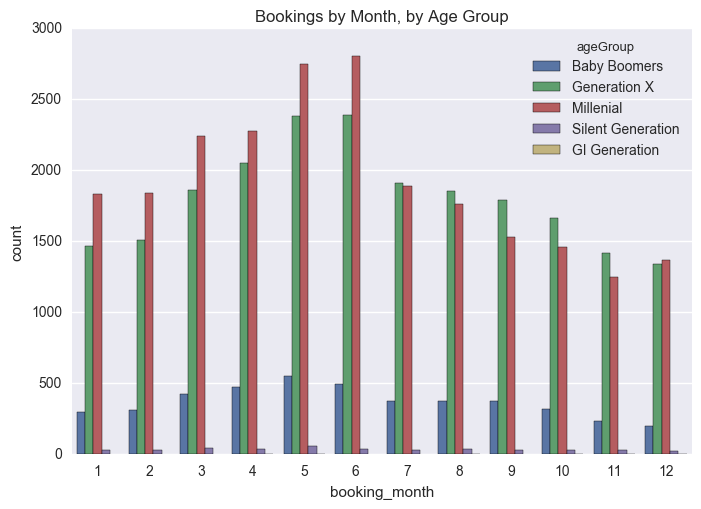

In [66]:
ax = sns.countplot(x='booking_month', data=bookings, hue='ageGroup')
ax.set_title('Bookings by Month, by Age Group')

In summary, we are exploring hotel bookings by Americans from 2010 to 2014. We've seen a trend of younger to middle age users making the most number bookings. Amongst these bookings, the users tend to book domestically. Among international bookings, approximately half of the bookings are still in English speaking countries. Females tend to book slightly more than males, and also tend to be slightly more adventurous in their country choices. The largest demographic of bookings are from female millenials. Lets test our findinging formally. 

## Significance Testing

We want to test the following hypotheses in order to decide which variables are significant predictors of booking destinations: 

1. Gender
2. Age Group
3. Booking Year
4. Booking Month
5. International Language Preference
6. Signup Method

In [132]:
from scipy import stats

### 1. Is gender a significant predictor of booking destination? 

Null Hypothesis: There is no association between gender and booking destination

Alternative Hypothesis: Gender is associated with booking destination.

We will test this using the Chi Squared test of independence for gender and booking destination.

In [154]:
pd.crosstab(bookings.gender, bookings['country_destination'])

country_destination,AU,CA,DE,ES,FR,GB,IT,NL,PT,US
gender,,,,,,,,,,
FEMALE,194,420,324,794,1791,810,1000,228,70,20988
MALE,172,447,389,619,1238,638,640,261,63,18281
OTHER,1,5,3,4,13,3,5,3,1,102


In [163]:
bookingsByGender = pd.crosstab(bookings.gender, bookings['country_destination'])
stats.chi2_contingency(bookingsByGender, correction=True)[1]

3.4216732244424105e-18

Our test results in a p-value close to 0 (3.4e-18). We can reject the null hypothesis with significance $\alpha = 0.0001$ . We have evidence to believe that gender is a predictor in destination. 

### 2. Is age a significant predictor of booking destination? 

Null Hypothesis: There is no association between age group and booking destination

Alternative Hypothesis: Age Group is associated with booking destination.

We will conduct a similar test, but using our defined age groups.

In [146]:
pd.crosstab(bookings.ageGroup, bookings['country_destination'])

country_destination,AU,CA,DE,ES,FR,GB,IT,NL,PT,US
ageGroup,,,,,,,,,,
Baby Boomers,39,97,81,112,326,193,174,42,15,3350
GI Generation,0,1,0,0,0,0,1,1,0,10
Generation X,170,399,306,593,1414,642,726,213,51,17123
Millenial,155,369,323,702,1261,594,715,229,66,18584
Silent Generation,3,6,6,10,41,22,29,7,2,304


In [162]:
bookingsByAge = pd.crosstab(bookings.ageGroup, bookings['country_destination'])
stats.chi2_contingency(bookingsByAge, correction=True)[1]

6.9042392296057068e-19

Again, our test results in a p-value close to 0 (6.9e-19). We can reject the null hypothesis with significance $\alpha = 0.0001$ . We have evidence to believe that age group is a predictor in destination. 

### 3. Is booking year a significant predictor of booking destination? 

Null Hypothesis: There is no association between booking year and booking destination

Alternative Hypothesis: Booking year is associated with booking destination.

In other words, were the booking distributions different year to year due to the global political climate or current events? 

In [158]:
pd.crosstab(bookings['booking_year'], bookings['country_destination'])

country_destination,AU,CA,DE,ES,FR,GB,IT,NL,PT,US
booking_year,,,,,,,,,,
2010,3,13,9,19,58,8,13,5,0,490
2011,19,60,47,87,213,83,81,34,11,2147
2012,73,191,180,306,667,336,373,98,25,7520
2013,143,281,270,511,1123,515,570,176,46,13740
2014,120,315,203,481,933,477,588,169,48,14485
2015,9,12,7,13,48,32,20,10,4,989


In [161]:
bookingsByYear = pd.crosstab(bookings['booking_year'], bookings['country_destination'])
stats.chi2_contingency(bookingsByYear, correction=True)[1]

4.7182739228273674e-20

Once again, our test results in a p-value close to 0 (4.7e-19). We can reject the null hypothesis with significance $\alpha = 0.0001$ . We have evidence to believe that booking year is a predictor in destination. 

### 4. Is booking month a significant predictor of booking destination? 


Null Hypothesis: There is no association between booking month and booking destination

Alternative Hypothesis: Booking month is associated with booking destination.


In [164]:
pd.crosstab(bookings['booking_month'], bookings['country_destination'])

country_destination,AU,CA,DE,ES,FR,GB,IT,NL,PT,US
booking_month,,,,,,,,,,
1,37,29,39,64,186,102,102,20,6,3042
2,36,49,44,101,230,109,117,30,12,2969
3,42,57,54,131,311,131,164,43,11,3627
4,24,98,71,169,337,138,197,40,16,3748
5,31,115,98,215,439,201,240,67,10,4320
6,18,137,86,222,378,195,206,75,28,4383
7,25,94,69,150,207,128,162,53,7,3314
8,18,83,80,116,261,107,128,53,12,3176
9,29,66,76,98,216,106,127,35,11,2958


In [165]:
bookingsByMonth = pd.crosstab(bookings['booking_month'], bookings['country_destination'])
stats.chi2_contingency(bookingsByMonth, correction=True)[1]

3.7703467695082948e-63

Again, our test results in a p-value close to 0 (3.8e-63, our most significant test so far). We can reject the null hypothesis with significance $\alpha = 0.0001$ . We have evidence to believe that booking month is a predictor in destination. 

### 5. Is international language preference a significant predictor of booking destination? 


Null Hypothesis: There is no association between international language preference and booking destination

Alternative Hypothesis: International language preference is associated with booking destination.

In [180]:
pd.crosstab(bookings.language, bookings['country_destination'])


country_destination,AU,CA,DE,ES,FR,GB,IT,NL,PT,US
language,,,,,,,,,,
ca,0,0,0,0,0,0,0,0,0,2
cs,0,0,0,1,0,0,0,0,0,3
da,0,0,0,2,0,0,1,0,0,11
de,2,0,17,6,6,2,5,2,1,114
el,0,0,0,2,1,0,0,0,0,2
en,363,862,684,1363,2957,1425,1602,480,130,38327
es,0,0,4,13,8,4,6,1,1,129
fi,0,0,0,0,1,0,0,0,0,4
fr,2,5,5,10,42,7,8,3,2,169


In [181]:
bookingsByLanguage = pd.crosstab(bookings.language=='en', bookings['country_destination'])
stats.chi2_contingency(bookingsByLanguage, correction=True)[1]

0.00018573414405430712

We can reject the null hypothesis with significance $\alpha = 0.001$. Note, when actually conducting the independence test, we test for language preference of English or Not English due to the limited number of data points with non English international language preference.

### 6. Is signup method a significant predictor of booking destination? 

Did the fact that the user signed up through the website, google, or facebook have an association with the destination country?


Null Hypothesis: There is no association between signup method and booking destination

Alternative Hypothesis: Signup method is associated with booking destination.

In [167]:
pd.crosstab(bookings['signup_method'], bookings['country_destination'])

country_destination,AU,CA,DE,ES,FR,GB,IT,NL,PT,US
signup_method,,,,,,,,,,
basic,228,561,404,801,1843,878,996,300,71,23235
facebook,139,310,311,615,1198,573,648,192,62,16097
google,0,1,1,1,1,0,1,0,1,39


In [172]:
bookingsBySignup = pd.crosstab(bookings['signup_method'], bookings['country_destination'])
bookingsBySignup = bookingsBySignup.transpose()[['basic', 'facebook']]
stats.chi2_contingency(bookingsBySignup, correction=True)[1]

0.0032125693774593877

We exclude Google due to the limited data points. We can reject the null hypothesis with significance $\alpha = 0.01$, but not $\alpha = 0.001$. We have evidence to believe that signup is a predictor in destination, but our evidence is not as strong as the previous tests. 

# Modeling

We will now attempt to build a predictive model using the six variables we deemed predictors of country destintation with statistical significance. Because we need to predict a categorical variable, we will attempt to use logistic or multiclass regression. We are working exclusively with categorical variables, so we will need to encode them as indicator variables in order to build a model.